# Анализатор технического состояния транспортерной ленты конвейерного оборудования.
Задача: предсказание целевого класса:
0 - Лента с растрескиванием рабочей поврехности в результате температурного воздействия (температурное старение);
1 - Участок ленты со стыковым соединением (исправным);
2 - Участок ленты с поврежденным краем;
3 - Лента без дефектов.
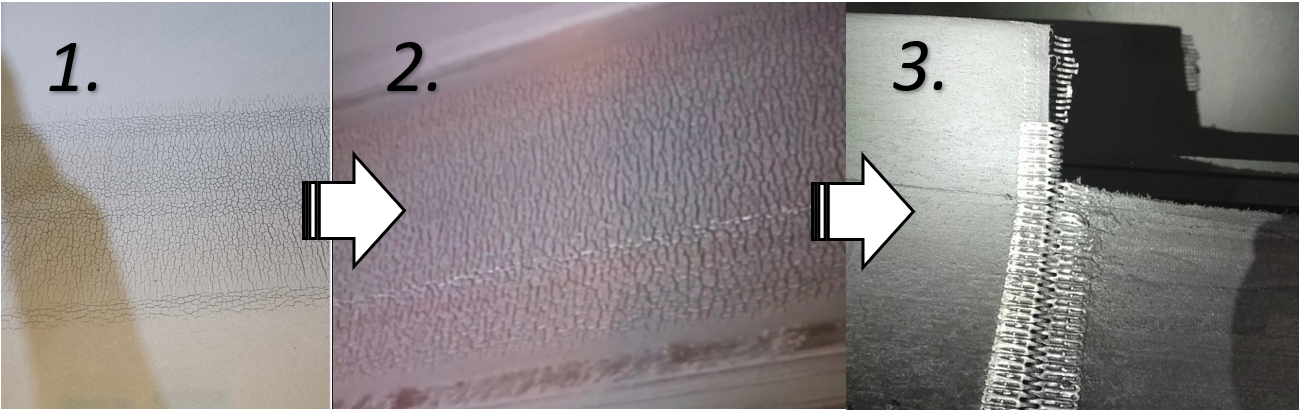

Подключаем облачный накопитель - гугл диск

In [ ]:
import zipfile
import glob
from google.colab import drive
drive.mount('/content/drive')
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy as np
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import StratifiedKFold
import torch.nn.functional as F

Mounted at /content/drive


Добавляем адрес папки на гугл диске и скачиваем изображения

In [ ]:
folder_path = "/content/drive/My Drive/New_work"

In [ ]:
import os
folder_path = "/content/drive/My Drive/New_work"
file_list = os.listdir(folder_path)
num_files = len([f for f in file_list if os.path.isfile(os.path.join(folder_path, f))])
print(f"Количество файлов в папке {folder_path}: {num_files}")

Количество файлов в папке /content/drive/My Drive/New_work: 280


Создание датасета с информацией о изображениях

In [ ]:
dataset = []

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)

        # Присвоение класса на основе первой цифры в названии файла, начиная с 0
        class_label = int(filename.split('.')[0][0]) - 1

        # Создание нового объекта изображения для добавления в датасет
        image_new = Image.open(image_path)
        dataset.append((image_new, class_label))  # Добавление нового объекта изображения и соответствующего класса в датасет

Визуализируем предварительно классифицированые изображения участков ленты

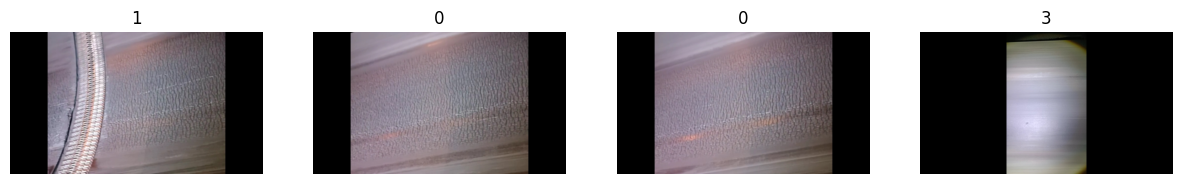

In [ ]:
# Перемешивание датасета
random.shuffle(dataset)

# Отображение случайных изображений из датасета
num_images = 4  # Количество изображений для отображения
plt.figure(figsize=(15, 7))

for i in range(num_images):
    image, filename = dataset[i]
    plt.subplot(1, num_images, i+1)
    plt.imshow(image)
    plt.title(filename)
    plt.axis('off')

plt.show()

С целью снижения влияния положения камеры и освещенности рабочего места производим аугментацию данных

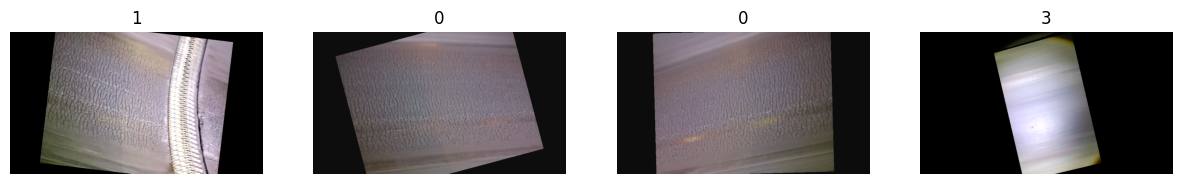

In [ ]:
# Аугментация изображений для увеличения датасета
transformed_dataset = []
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Случайное отражение по горизонтали с вероятностью 50%
    transforms.RandomRotation(degrees=(-15, 15)),  # Случайный поворот на угол от -15 до 15 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)  # Изменение цветовых характеристик
])

for image, label in dataset:
    image_augmented = transform(image)
    transformed_dataset.append((image_augmented, label))

# Визуализация случайных изображений из аугментированного датасета
plt.figure(figsize=(15, 7))
for i in range(num_images):
    image_augmented, label = transformed_dataset[i]
    plt.subplot(1, num_images, i+1)
    plt.imshow(image_augmented)
    plt.title(label)
    plt.axis('off')

plt.show()

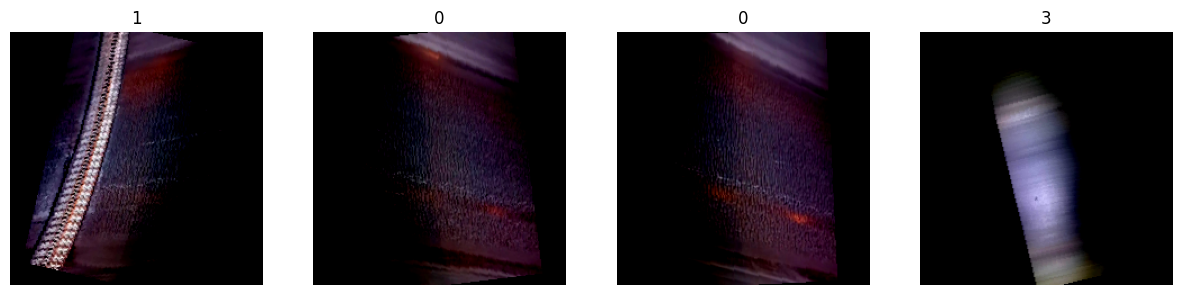

In [ ]:
# Преобразование изображений к размеру 225*225 и нормализация
transform = transforms.Compose([
    transforms.Resize((225, 225)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])
# Преобразование изображений и нормализация
transformed_dataset = []

for image, filename in dataset:
    image = transform(image)
    transformed_dataset.append((image, filename))
# Визуализация преобразованных цветных изображений
plt.figure(figsize=(15, 7))

for i in range(num_images):
    image, filename = transformed_dataset[i]
    image_np = image.numpy().transpose((1, 2, 0))  # Перестановка осей для отображения цветного изображения
    plt.subplot(1, num_images, i+1)
    plt.imshow(image_np)
    plt.title(str(filename))
    plt.axis('off')

plt.show()

# Разделение датасета на обучающую, валидационную и тестовую выборки
train_size = int(0.6 * len(transformed_dataset))
val_size = int(0.2 * len(transformed_dataset))
test_size = len(transformed_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(transformed_dataset, [train_size, val_size, test_size])

# Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Используем предобученную модель resnet18 и дообучаем ее на наших данных

In [ ]:
# Загрузка предобученной модели ResNet
model = models.resnet18(pretrained=True)

# Заморозка всех параметров слоев модели ResNet
for param in model.parameters():
    param.requires_grad = False

# Замена последнего полносвязного слоя на новый слой с количеством выходных классов
num_classes = 4  # Количество классов в вашем датасете
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Разделение датасета на обучающую и тестовую выборки
train_size = int(0.8 * len(transformed_dataset))
test_size = len(transformed_dataset) - train_size
train_dataset, test_dataset = random_split(transformed_dataset, [train_size, test_size])

# Создание DataLoader для обучающей и тестовой выборок
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.6MB/s]


Epoch 1, Loss: 0.22320552170276642, Accuracy: 0.8928571428571429
Epoch 2, Loss: 0.30618909001350403, Accuracy: 0.9464285714285714
Epoch 3, Loss: 0.426710844039917, Accuracy: 0.9107142857142857
Epoch 4, Loss: 0.17466306686401367, Accuracy: 0.9464285714285714
Epoch 5, Loss: 0.05251380056142807, Accuracy: 0.9285714285714286
Epoch 6, Loss: 0.09567075222730637, Accuracy: 0.9285714285714286
Epoch 7, Loss: 0.12407790869474411, Accuracy: 0.9285714285714286
Epoch 8, Loss: 0.15326456725597382, Accuracy: 0.9285714285714286
Epoch 9, Loss: 0.2627158761024475, Accuracy: 0.9464285714285714
Epoch 10, Loss: 0.16848555207252502, Accuracy: 0.9464285714285714
Epoch 11, Loss: 0.14531643688678741, Accuracy: 0.9464285714285714
Epoch 12, Loss: 0.1351390928030014, Accuracy: 0.9464285714285714
Epoch 13, Loss: 0.07102015614509583, Accuracy: 0.9464285714285714
Epoch 14, Loss: 0.06787431240081787, Accuracy: 0.9285714285714286
Epoch 15, Loss: 0.20100662112236023, Accuracy: 0.9464285714285714
Epoch 16, Loss: 0.19438

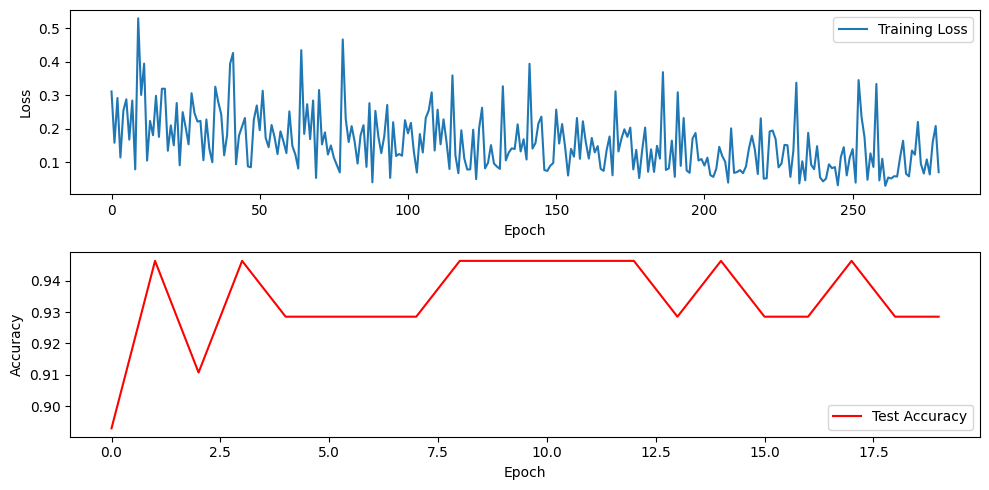

In [ ]:
# Обучение модели
num_epochs = 20

train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    total = 0
    correct = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch+1}, Loss: {train_losses[-1]}, Accuracy: {accuracy}")
torch.save(model.state_dict(), 'trained_model.pth')
# Вывод графика ошибки и точности
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Переводим модель в режим тестирования

In [ ]:
best_accuracy = 0
patience = 3
counter = 0

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    total = 0
    correct = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch + 1}, Loss: {train_losses[-1]}, Accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        counter = 0
        # Сохранение лучших весов модели
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

# Загрузка лучших весов модели
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

Epoch 1, Loss: 0.3204059898853302, Accuracy: 0.875
Epoch 2, Loss: 0.4708084464073181, Accuracy: 0.8928571428571429
Epoch 3, Loss: 0.3226528465747833, Accuracy: 0.8928571428571429
Epoch 4, Loss: 0.1902218908071518, Accuracy: 0.9107142857142857
Epoch 5, Loss: 0.4471243917942047, Accuracy: 0.875
Epoch 6, Loss: 0.18800130486488342, Accuracy: 0.9107142857142857
Epoch 7, Loss: 0.19410644471645355, Accuracy: 0.9285714285714286
Epoch 8, Loss: 0.11938224732875824, Accuracy: 0.875
Epoch 9, Loss: 0.18144044280052185, Accuracy: 0.9285714285714286
Epoch 10, Loss: 0.3190595805644989, Accuracy: 0.9107142857142857
Early stopping at epoch 10


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Для проверки работы модели загружаем изображение из тренировочной выборки. После обработки моделью получаем заключение о состоянии ленты.

In [ ]:
# Загрузка и предобработка изображения
image_path = '/content/r.jpg'  # Путь к загруженному изображению
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)

# Производим классификацию изображения
with torch.no_grad():
    output = model(image_tensor)
    output = F.softmax(output, dim=1)  # Применяем софтмакс для получения вероятностей
    predicted_class = torch.argmax(output).item()

# Описание класса
class_descriptions = {
    0: 'Лента с растрескиванием рабочей поврехности в результате температурного воздействия (температурное старение)',
    1: 'Лента со стыковым соединением (исправным)',
    2: 'Лента с поврежденным краем',
    3: 'Лента без дефеков'
    # Добавьте описания для остальных классов
}

# Вывод предсказанного класса и его описания
print(f'Predicted class: {predicted_class}')
print(f'Class description: {class_descriptions[predicted_class]}')

Predicted class: 2
Class description: Лента с поврежденным краем


# После обработки моделью получаем заключение о состоянии ленты. Классификатор можно использовать для выявления наличия или отсутствия дефектов на ленте, с целью дальнейшего принятия решения о дальнейшей визуальной диагностике с привлечением специалистов сервисной организации или с помощью алгоритмов детекции и сегментации. Такой алгоритм работы можно применять для диагностирования большинства конвейерного оборудования, т. к. он прост в реализации и успешно решает задачи контроля его исправного состояния.